# **Atelier : Estimation floue du risque de défaillance d’un équipement industriel**

Ce notebook présente, étape par étape, la mise en place d’un système intelligent associant la logique floue et l’apprentissage automatique afin d’évaluer la probabilité de panne d’un équipement en se basant sur plusieurs paramètres incertains tels que la température, les vibrations et l’ancienneté de la machine.

In [3]:
!pip install scikit-fuzzy
!pip install networkx
!pip install scikit-fuzzy
!pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 15.0 MB/s eta 0:00:00


Q1: Création d'un contrôleur flou avec les variables:

In [5]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
# Définition des variables floues
temp_mach = ctrl.Antecedent(np.arange(0, 101, 1), 'temp_mach')
vib_mach = ctrl.Antecedent(np.arange(0, 11, 1), 'vib_mach')
anciennete = ctrl.Antecedent(np.arange(0, 21, 1), 'anciennete')
niveau_risque = ctrl.Consequent(np.arange(0, 11, 1), 'niveau_risque')

# Fonctions d’appartenance
temp_mach['basse'] = fuzz.trimf(temp_mach.universe, [0, 0, 40])
temp_mach['normale'] = fuzz.trimf(temp_mach.universe, [30, 50, 70])
temp_mach['haute'] = fuzz.trimf(temp_mach.universe, [60, 100, 100])

vib_mach['legere'] = fuzz.trimf(vib_mach.universe, [0, 0, 4])
vib_mach['moderee'] = fuzz.trimf(vib_mach.universe, [2, 5, 8])
vib_mach['intense'] = fuzz.trimf(vib_mach.universe, [6, 10, 10])

anciennete['recente'] = fuzz.trimf(anciennete.universe, [0, 0, 7])
anciennete['intermediaire'] = fuzz.trimf(anciennete.universe, [5, 10, 15])
anciennete['vieille'] = fuzz.trimf(anciennete.universe, [12, 20, 20])

niveau_risque['faible'] = fuzz.trimf(niveau_risque.universe, [0, 0, 4])
niveau_risque['moyen'] = fuzz.trimf(niveau_risque.universe, [2, 5, 8])
niveau_risque['eleve'] = fuzz.trimf(niveau_risque.universe, [6, 10, 10])


Q2: Définition des règles d’inférence floues


In [6]:
# Définition des règles floues
reg1 = ctrl.Rule(temp_mach['haute'] | vib_mach['intense'], niveau_risque['eleve'])
reg2 = ctrl.Rule(anciennete['vieille'] & vib_mach['moderee'], niveau_risque['moyen'])
reg3 = ctrl.Rule(temp_mach['basse'] & vib_mach['legere'] & anciennete['recente'], niveau_risque['faible'])
reg4 = ctrl.Rule(temp_mach['normale'] & anciennete['intermediaire'], niveau_risque['moyen'])

# Système de contrôle flou
controleur = ctrl.ControlSystem([reg1, reg2, reg3, reg4])


# Machine Learning:
 Génération d’un jeu de données synthétique


In [7]:
# Génération d’un dataset aléatoire à partir du système flou
nb_points = 2000
echantillons = []

for _ in range(nb_points):
    sim_fuzzy = ctrl.ControlSystemSimulation(controleur)

    temp = np.random.uniform(0, 100)
    vib = np.random.uniform(0, 10)
    age_mach = np.random.uniform(0, 20)

    sim_fuzzy.input['temp_mach'] = temp
    sim_fuzzy.input['vib_mach'] = vib
    sim_fuzzy.input['anciennete'] = age_mach

    try:
        sim_fuzzy.compute()
        risque_val = sim_fuzzy.output.get('niveau_risque', np.nan)
    except:
        risque_val = np.nan

    echantillons.append([temp, vib, age_mach, risque_val])

# Création du DataFrame
df_fuzzy = pd.DataFrame(echantillons, columns=['Température', 'Vibrations', 'Âge_machine', 'Risque_pred'])
df_fuzzy.dropna(inplace=True)
df_fuzzy.head()


,Température,Vibrations,Âge_machine,Risque_pred
0,24.436606,9.499763,3.948625,8.648132
1,23.687137,9.405232,5.844390,8.641004
2,96.159724,4.662150,10.544928,8.655453
3,8.884577,3.729034,4.957266,1.933050
4,46.329526,8.137747,5.379002,7.742239


##  Entraînement d’un modèle Machine Learning
On utilise un **Gradient Boosting** pour apprendre à prédire le risque à partir des trois entrées.
Il combine plusieurs arbres faibles pour corriger les erreurs des précédents (effet d’ensemble séquentiel).

Il apprend progressivement les relations complexes entre température, vibration et âge.

Il donne souvent des performances supérieures à RandomForest sur de petits datasets bruités.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

# Séparation des données
X = df_fuzzy[['Température', 'Vibrations', 'Âge_machine']]
y = df_fuzzy['Risque_pred']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle de régression basé sur le Gradient Boosting
gbr_model = GradientBoostingRegressor(
    n_estimators=200,    # nombre d'arbres
    learning_rate=0.05,  # taux d'apprentissage
    max_depth=4,         # profondeur des arbres
    random_state=42
)

# Entraînement
gbr_model.fit(X_train, y_train)

# Prédictions
y_pred = gbr_model.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


# Calcul du R²
r2 = r2_score(y_test, y_pred)

print(f"Erreur Absolue Moyenne (MAE): {mae:.4f}")

print(f"Coefficient de Détermination (R²): {r2:.4f}")

print(f"Erreur Quadratique Moyenne (MSE): {mse:.4f}")



Erreur Absolue Moyenne (MAE): 0.2000
Coefficient de Détermination (R²): 0.9694
Erreur Quadratique Moyenne (MSE): 0.1114


##  Visualisation des résultats



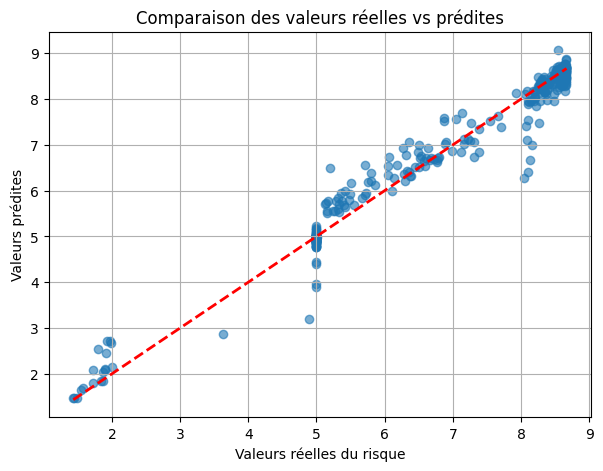

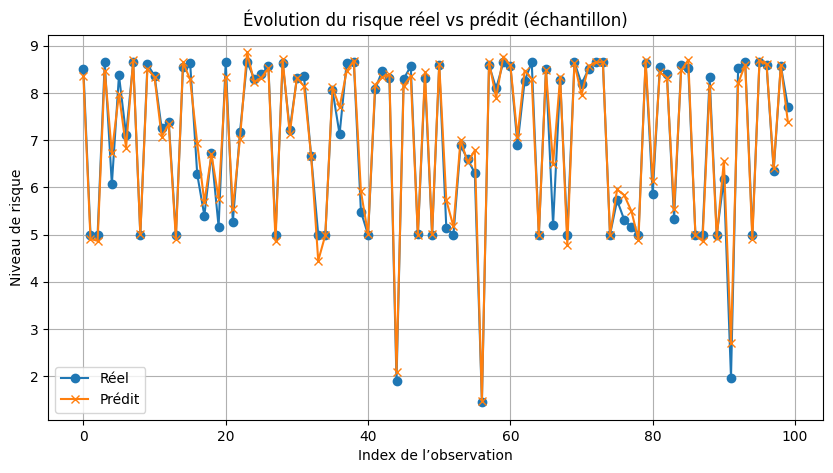

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Scatter plot : y_test vs y_pred
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Comparaison des valeurs réelles vs prédites")
plt.xlabel("Valeurs réelles du risque")
plt.ylabel("Valeurs prédites")
plt.grid(True)
plt.show()

# 2️⃣ Courbes comparées (sur un échantillon)
indices = np.arange(0, 100)  # afficher les 100 premiers
plt.figure(figsize=(10,5))
plt.plot(indices, y_test[:100].values, label='Réel', marker='o')
plt.plot(indices, y_pred[:100], label='Prédit', marker='x')
plt.title("Évolution du risque réel vs prédit (échantillon)")
plt.xlabel("Index de l’observation")
plt.ylabel("Niveau de risque")
plt.legend()
plt.grid(True)
plt.show()


# **Conclusion**

Ce travail a permis de combiner la logique floue et l’apprentissage automatique pour estimer le risque de panne d’une machine à partir de données incertaines.
Les règles floues ont apporté une explicabilité claire du raisonnement, tandis que le modèle de régression par Gradient Boosting a amélioré la précision des prédictions.
Les résultats obtenus (MAE, MSE, R² et graphiques) montrent que cette approche hybride est efficace et interprétable, offrant un bon équilibre entre performance et compréhension du système.